# Определение перспективного тарифа для телеком компании
## **Описание проекта**

 
Имеются данные клиентов «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
    
Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### Описание данных

Таблица `users` (информация о пользователях):

- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tarif* — название тарифного плана

Таблица `calls` (информация о звонках):

- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):

- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):

- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):

- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Импортируем библиотеки

In [1141]:
# для работы с данными
import pandas as pd
import numpy as np

# для работы с датой
import datetime
from dateutil import relativedelta

# Для работы со статистикой
from scipy import stats as st
from scipy.stats import norm

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

# Для Графиков
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [917]:
# Загрузим данные и сохраним в соответствующие переменные
df_users = pd.read_csv('prkt_project_users.csv')
df_calls = pd.read_csv('prkt_project_calls.csv')
df_messages = pd.read_csv('prkt_project_messages.csv')
df_internet = pd.read_csv('prkt_project_internet.csv')
df_tariffs = pd.read_csv('tariffs.csv')

### 1. Проверим основную информацию о данных

- Таблица users (информация о пользователях)

In [918]:
df_users.head(10) # Посмотрим первые 10 строк таблицы

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [919]:
df_users.info() # Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [920]:
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [921]:
# Постомтрим основные метрики категориальных данных
df_users.describe(include=['object'])

,churn_date,city,first_name,last_name,reg_date,tariff
count,38,500,500,500,500,500
unique,33,76,246,419,270,2
top,2018-12-03,Москва,Радим,Андреенко,2018-05-28,smart
freq,2,99,6,5,8,351


In [922]:
df_users.isna().sum().sort_values(ascending=False) # Проверим количество пропусков

churn_date    462
user_id         0
age             0
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [923]:
df_users.duplicated().sum() # Проверим количество дубликатов

0

- Таблица calls (информация о звонках)

In [924]:
df_calls.head(10) # Посмотрим первые 10 строк таблицы

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [925]:
df_calls.info() # Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [926]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [927]:
df_calls.isna().sum().sort_values(ascending=False) # Проверим количество пропусков

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [928]:
df_calls.duplicated().sum() # Проверим количество дубликатов

0

 - Таблица messages (информация о сообщениях)

In [929]:
df_messages.head(10) # Посмотрим первые 10 строк таблицы

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [930]:
df_messages.info() # Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [931]:
df_messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [932]:
df_messages.isna().sum().sort_values(ascending=False) # Проверим количество пропусков

id              0
message_date    0
user_id         0
dtype: int64

In [933]:
df_messages.duplicated().sum() # Проверим количество дубликатов

0

In [934]:
df_messages_per_day_user = df_messages.groupby(['user_id', 'message_date'], as_index=False)\
                                      .agg({'id': 'count'})\
                                      .rename(columns={'id': 'quantity'})

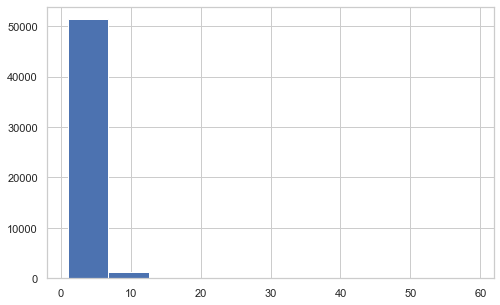

In [935]:
df_messages_per_day_user.quantity.hist();

На графике видно, что в основном пользователи отправляют до 15 сообщений в день, но есть выбросы

In [936]:
df_messages_per_day_user.query('quantity > 15')

,user_id,message_date,quantity
13996,1140,2018-12-31,31
34336,1336,2018-12-31,20
46731,1445,2018-12-29,32
46732,1445,2018-12-30,24
46733,1445,2018-12-31,19
51307,1485,2018-12-29,42
51308,1485,2018-12-30,59
51309,1485,2018-12-31,54


- Таблица internet (информация об интернет-сессиях)

In [937]:
df_internet.head(10) # Посмотрим первые 10 строк таблицы

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [938]:
df_internet.info() # Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [939]:
df_internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [940]:
df_internet.isna().sum().sort_values(ascending=False) # Проверим количество пропусков

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [941]:
df_internet.duplicated().sum() # Проверим количество дубликатов

0

- Таблица tariffs (информация о тарифах)

In [942]:
df_tariffs.head(10) # Посмотрим первые 10 строк таблицы

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [943]:
df_tariffs.info() # Проверим основную информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [944]:
df_tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [945]:
df_tariffs.isna().sum().sort_values(ascending=False) # Проверим количество пропусков

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

In [946]:
df_tariffs.duplicated().sum() # Проверим количество дубликатов

0

### Вывод
Ошибок в данных не найдено, дубликатов не обнаружено, необходимо привести к соответствующему виду дату и время


### 2.1. Подготовка данных

In [947]:
# Приведем даты к соответствующему типу
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')

### 2.2. Поиск ошибок.
Рассмотрим более детально данные из каждой таблицы. Таблицы будем смотреть по очереди в том же порядке.

In [948]:
# Посмотрим "время жизни" пользователей, среди тех, кто уже прекратил пользоваться тарифом
df_users['lifetime'] = (df_users['churn_date'] - df_users['reg_date']).dt.days

<AxesSubplot:>

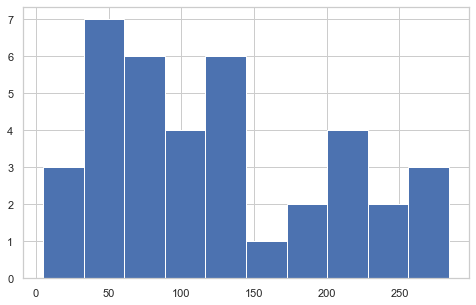

In [949]:
df_users['lifetime'].hist()

In [950]:
# Посмотрим, из каких городов пользователи
df_users.city.value_counts().head(10)

Москва              99
Санкт-Петербург     39
Новосибирск         16
Казань              14
Омск                14
Уфа                 12
Екатеринбург        11
Ульяновск           11
Набережные Челны    11
Краснодар           11
Name: city, dtype: int64

In [951]:
# Сколько всего городов представлено в таблице
df_users.city.nunique()

76

In [952]:
# Меньше всего пользователей в городах
df_users.city.value_counts(ascending=True).head(10)

Химки            1
Архангельск      1
Подольск         1
Иваново          1
Нижневартовск    1
Оренбург         2
Белгород         2
Грозный          2
Тамбов           2
Курск            2
Name: city, dtype: int64

<AxesSubplot:>

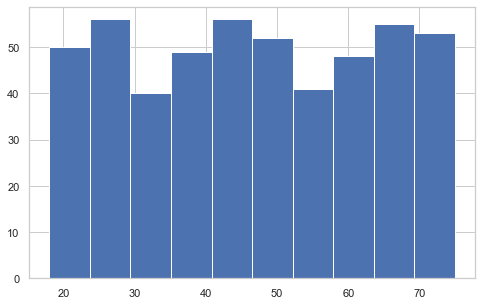

In [953]:
# Посмотрим возраст пользователей
df_users.age.hist()

In [954]:
# Посмотрим тарифы
df_users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [955]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [956]:
# Проверим, что данные действительно за 2018 год
df_calls.call_date.min()

Timestamp('2018-01-01 00:00:00')

In [957]:
df_calls.call_date.max()

Timestamp('2018-12-31 00:00:00')

In [958]:
# Посмотрим, сколько каждый пользователь делает в день звонков и какой длительности 
df_calls_per_day_user = df_calls.groupby(['user_id', 'call_date'], as_index=False)\
                                .agg({'id': 'count', 'duration': 'sum'})\
                                .rename(columns={'id': 'quantity'})

In [959]:
df_calls_per_day_user.head()

,user_id,call_date,quantity,duration
0,1000,2018-05-25,1,0.00
1,1000,2018-05-26,6,46.41
2,1000,2018-05-27,1,3.43
3,1000,2018-05-28,4,26.99
4,1000,2018-05-29,2,11.35


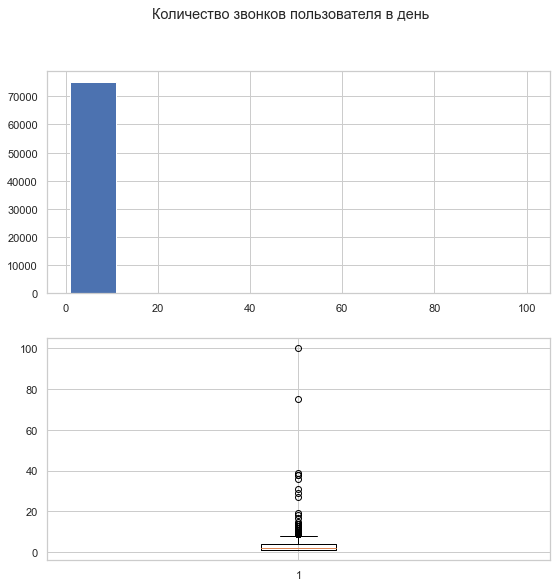

In [960]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
axs[0].hist(df_calls_per_day_user.quantity)
axs[1].boxplot(df_calls_per_day_user.quantity)
fig.suptitle('Количество звонков пользователя в день');

In [961]:
# Видим, что чаще всего пользотели звонят меньше 40 раз в день, посмотрим отдельно выбросы
df_calls_per_day_user.query('quantity >= 40')

,user_id,call_date,quantity,duration
20820,1140,2018-12-31,75,538.79
49919,1336,2018-12-31,100,712.05


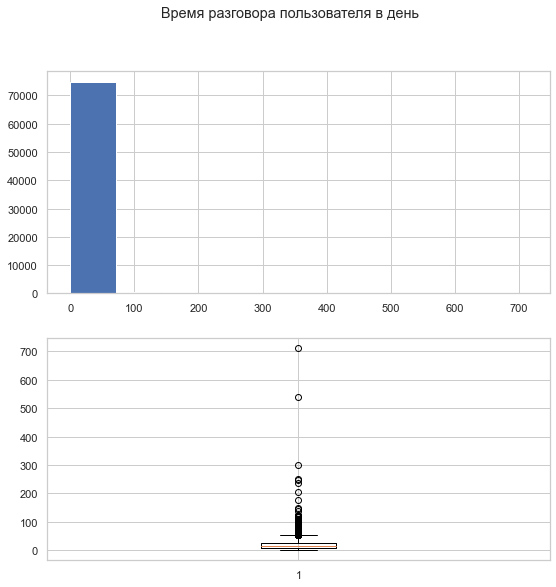

In [962]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
axs[0].hist(df_calls_per_day_user.duration)
axs[1].boxplot(df_calls_per_day_user.duration)
fig.suptitle('Время разговора пользователя в день');

In [963]:
# Видим, что чаще всего пользотели говорят по телефону меньше 300 минут в день, посмотрим выбросы
df_calls_per_day_user.query('duration >= 300')

,user_id,call_date,quantity,duration
11209,1074,2018-12-30,36,300.50
20820,1140,2018-12-31,75,538.79
49919,1336,2018-12-31,100,712.05


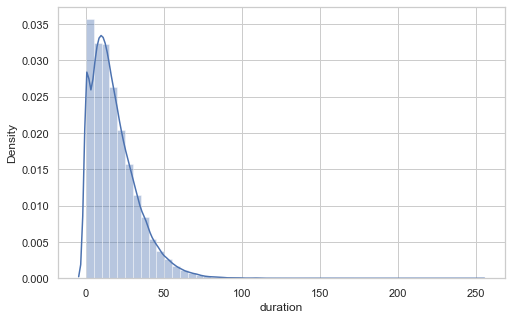

In [964]:
# Посмотрим более одробно распределение данных без выбросов
sns_plot = sns.distplot(df_calls_per_day_user.query('duration < 300').duration)
fig = sns_plot.get_figure()

Видно, что несколько пользователей намного больше говорили по телефону перед Новым годом, 29-31 декабря

Проверим, сколько обычно длится один звонок и есть ли выбросы.

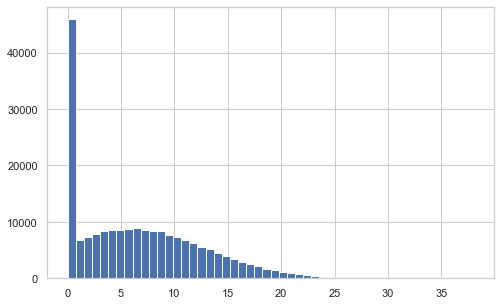

In [965]:
df_calls['duration'].hist(bins=50)
plt.show()

На гистограмме видно много нулевых значений. Сильных выбросов нет. Звонки с нулевой длительностью скорее всего соответствуют попыткам дозвониться. Эта информация была бы полезна при определении причины отказа от услуг или для определения периодов с проблемами связи.

In [966]:
# Посмотрим подробнее данные по сообщениям, посчитаем количество сообщений пользователя в день
df_messages_per_day_user = df_messages.groupby(['user_id', 'message_date'], as_index=False)\
                                      .agg({'id': 'count'})\
                                      .rename(columns={'id': 'quantity'})

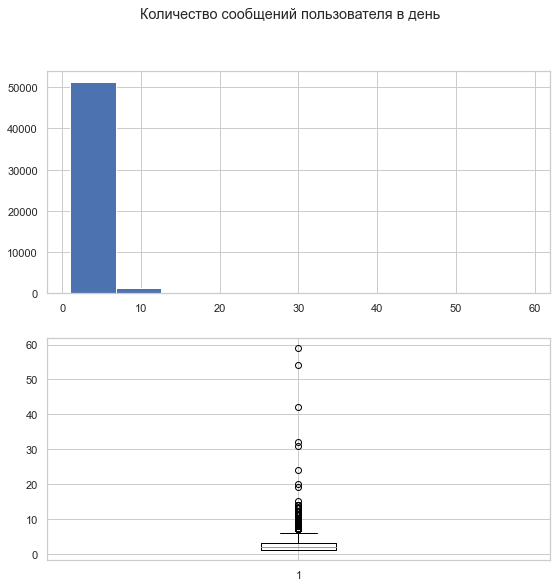

In [967]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
axs[0].hist(df_messages_per_day_user.quantity)
axs[1].boxplot(df_messages_per_day_user.quantity)
fig.suptitle('Количество сообщений пользователя в день');

In [968]:
# На графике видно, что в основном пользователи отправляют до 15 сообщений в день, но есть выбросы
df_messages_per_day_user.query('quantity > 15')

,user_id,message_date,quantity
13996,1140,2018-12-31,31
34336,1336,2018-12-31,20
46731,1445,2018-12-29,32
46732,1445,2018-12-30,24
46733,1445,2018-12-31,19
51307,1485,2018-12-29,42
51308,1485,2018-12-30,59
51309,1485,2018-12-31,54


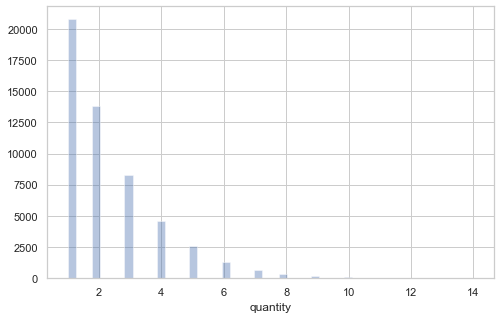

In [969]:
sns_plot = sns.distplot(df_messages_per_day_user.query('quantity < 15').quantity, kde=False)
fig = sns_plot.get_figure()

Тут тоже видно, что перед новым годом люди выслали существенно больше сообщений, чем обычно.

Проверим данные по интернет-сессиям.

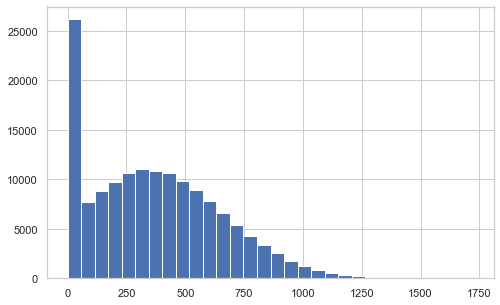

In [970]:
df_internet['mb_used'].hist(bins=30)
plt.show()

In [971]:
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [972]:
# Посмотрим подробнее данные интернет-траффика, посчитаем количество сообщений пользователя в день
df_internet_per_day_user = df_internet.groupby(['user_id', 'session_date'], as_index=False)\
                                      .agg({'id': 'count', 'mb_used': 'sum'})\
                                      .rename(columns={'id': 'quantity'})

In [973]:
df_internet_per_day_user.head()

,user_id,session_date,quantity,mb_used
0,1000,2018-05-26,1,0.00
1,1000,2018-05-28,2,907.42
2,1000,2018-05-31,2,1346.07
3,1000,2018-06-01,2,1611.41
4,1000,2018-06-03,2,951.72


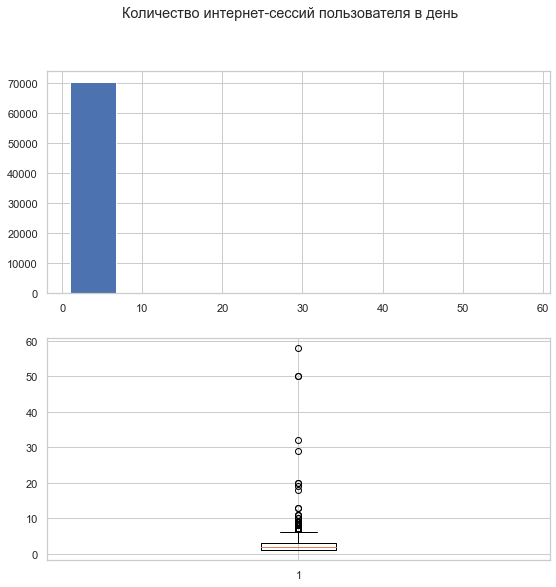

In [974]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
axs[0].hist(df_internet_per_day_user.quantity)
axs[1].boxplot(df_internet_per_day_user.quantity)
fig.suptitle('Количество интернет-сессий пользователя в день');

In [975]:
# На графике видно, что в основном пользователи осуществляют до 20 сессий в день, но есть выбросы
df_messages_per_day_user.query('quantity > 20')

,user_id,message_date,quantity
13996,1140,2018-12-31,31
46731,1445,2018-12-29,32
46732,1445,2018-12-30,24
51307,1485,2018-12-29,42
51308,1485,2018-12-30,59
51309,1485,2018-12-31,54


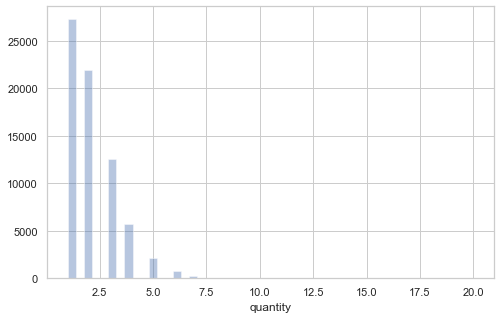

In [976]:
# Посмотрим тот же график без выбросов
sns_plot = sns.distplot(df_internet_per_day_user.query('quantity <= 20').quantity, kde=False)
fig = sns_plot.get_figure()

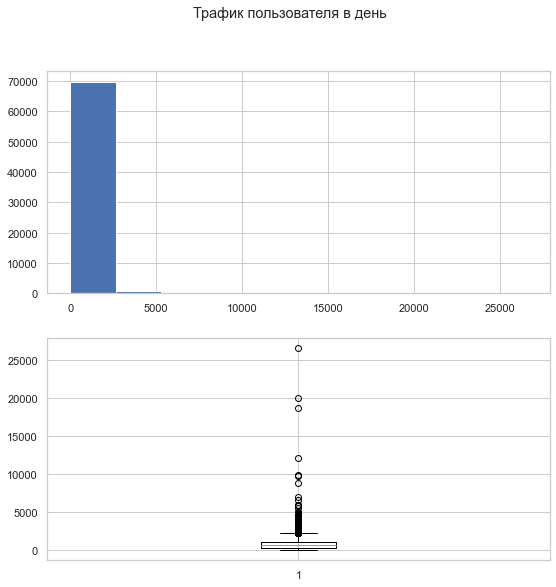

In [977]:
fig, axs = plt.subplots(2, 1, figsize=(9, 9))
axs[0].hist(df_internet_per_day_user.mb_used)
axs[1].boxplot(df_internet_per_day_user.mb_used
              )
fig.suptitle('Трафик пользователя в день');

In [978]:
# На графике видно, что в основном пользователи используют до 10000 Мб в день, но есть выбросы
df_internet_per_day_user.query('mb_used > 10000')

,user_id,session_date,quantity,mb_used
10385,1074,2018-12-31,32,12185.53
19042,1140,2018-12-31,58,20046.38
36122,1258,2018-12-31,50,18698.14
47009,1336,2018-12-31,50,26582.01


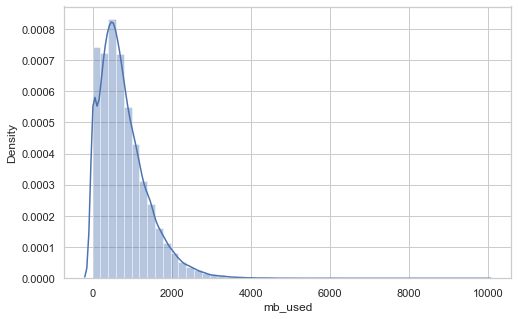

In [979]:
# Посмотрим тот же график без выбросов
sns_plot = sns.distplot(df_internet_per_day_user.query('mb_used < 10000').mb_used)
fig = sns_plot.get_figure()

### Вывод
Ошибок в данных не найдено, но есть несколько выбросов, дальше нужно будет это учесть

### 2.3. Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам.
Обычно дата расчета оплаты совпадает с датой регистрации, соответственно месяцы нужно считать не с первого числа, а с даты регистрации, в расчете будем это учитывать.

In [980]:
# Округлим минуты и Мегабайты до верхнего значения
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_internet['mb_used'] = np.ceil(df_internet['mb_used']).astype(int)

In [981]:
# Добавим в таблицу со звонками данные о дате регистрации пользователей
df_calls = df_calls.merge(df_users[['reg_date', 'user_id']], how='right', on='user_id')

In [982]:
# Удалим пропущенные значения
df_calls.dropna(inplace=True)

In [983]:
# Найдем разницу между датой звонка и датой регистрации
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month - pd.DatetimeIndex(df_calls['reg_date']).month

In [984]:
# Прибавим к месяцу регистрации количество полных месяцев, которые прошли после регистрации
df_calls['month'] = df_calls['month'] + pd.DatetimeIndex(df_calls['reg_date']).month

In [985]:
#Удалим колонку с датой регистрации, т.к. она нам больше не нужна
df_calls = df_calls.drop(columns='reg_date')

In [986]:
calls_by_month = df_calls.groupby(['user_id', 'month'], as_index=False)\
        .agg({'call_date': 'count', 'duration': 'sum'})\
        .rename(columns={'call_date': 'calls_quantity'})

In [987]:
calls_by_month.head()

,user_id,month,calls_quantity,duration
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


### 2.4. Посчитаем количество отправленных сообщений по месяцам.

In [988]:
# Повторим те же действия для таблицы с сообщениями, можно было бы выделить это в функцию.
# Добавим в таблицу с сообщениями данные о дате регистрации пользователей
df_messages = df_messages.merge(df_users[['reg_date', 'user_id']], how='right', on='user_id')

# Удалим пропущенные значения
df_messages.dropna(inplace=True)

# Найдем разницу между датой звонка и датой регистрации
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month - pd.DatetimeIndex(df_messages['reg_date']).month

# Прибавим к месяцу регистрации количество полных месяцев, которые прошли после регистрации
df_messages['month'] = df_messages['month'] + pd.DatetimeIndex(df_messages['reg_date']).month

#Удалим колонку с датой регистрации, т.к. она нам больше не нужна
df_messages = df_messages.drop(columns='reg_date')

messages_by_month = df_messages.groupby(['user_id', 'month'], as_index=False)\
        .agg({'message_date': 'count'})\
        .rename(columns={'message_date': 'messages_quantity'})

In [989]:
messages_by_month.head()

,user_id,month,messages_quantity
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### 2.5. Найдем объем израсходованного интернет-трафика по месяцам.

In [990]:
# Повторим те же действия для таблицы с сообщениями, можно было бы выделить это в функцию.
# Добавим в таблицу с сообщениями данные о дате регистрации пользователей
df_internet = df_internet.merge(df_users[['reg_date', 'user_id']], how='right', on='user_id')

# Удалим пропущенные значения
df_internet.dropna(inplace=True)

# Найдем разницу между датой звонка и датой регистрации
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month - pd.DatetimeIndex(df_internet['reg_date']).month

# Прибавим к месяцу регистрации количество полных месяцев, которые прошли после регистрации
df_internet['month'] = df_internet['month'] + pd.DatetimeIndex(df_internet['reg_date']).month

#Удалим колонку с датой регистрации, т.к. она нам больше не нужна
df_internet = df_internet.drop(columns='reg_date')

internet_by_month = df_internet.groupby(['user_id', 'month'], as_index=False)\
        .agg({'session_date': 'count', 'mb_used': 'sum'})\
        .rename(columns={'session_date': 'sessions_quantity'})

In [991]:
internet_by_month.head()

,user_id,month,sessions_quantity,mb_used
0,1000,5,5,2256.0
1,1000,6,49,23257.0
2,1000,7,29,14016.0
3,1000,8,29,14070.0
4,1000,9,27,14581.0


### 2.6. Найдем помесячную выручку с каждого пользователя.

In [992]:
#Сгруппируем суммарное количество минут по месяцам
pivot_calls_by_month = (
    calls_by_month
    .pivot_table(index='user_id', columns='month', values='duration', aggfunc=('sum')))

In [993]:
# Добавим к таблице звонков тариф каждого пользователя
pivot_calls_by_month = pivot_calls_by_month.merge(df_users[['tariff', 'user_id']], how='left', on='user_id')

In [994]:
# Добавим информацию о тарифах, нужную для расчета
pivot_calls_by_month = pivot_calls_by_month.merge(df_tariffs[['tariff_name', 'minutes_included', 'rub_per_minute']],
                                        how='left', left_on='tariff', right_on='tariff_name')

In [995]:
pivot_calls_by_month.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff,tariff_name,minutes_included,rub_per_minute
0,1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0,ultra,ultra,3000,1
1,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0,smart,smart,500,3
2,1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0,smart,smart,500,3
3,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0,ultra,ultra,3000,1
4,1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0,ultra,ultra,3000,1


In [996]:
# Создадим функцию для расчета количества израсходованных минут в месяц
# Расчитаем стоимость платных звонков
def calls_income_counter (df):
    for i in range(12):
        if (df['minutes_included'] - df[i+1]) >= 0:
            df[i+1] = 0
        else: 
            df[i+1] = (df[i+1] - df['minutes_included']) * df['rub_per_minute']
    return df

In [997]:
# Применим функцию к датафрейму
calls_income = pivot_calls_by_month.apply(calls_income_counter, axis=1)

In [998]:
# Уберем вспомогательные колонки используемые в расчете
calls_income = calls_income.drop(columns=['tariff', 'tariff_name', 'minutes_included', 'rub_per_minute'])

In [999]:
#Добавим всех пользователей, т.к. в исходной, только те, кто пользовался связью
calls_income = calls_income.merge(df['user_id'], how='right', on='user_id').sort_values(by='user_id')
#Установим user_id как индекс
calls_income = calls_income.set_index('user_id')

In [1000]:
calls_income.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Расчитаем плату за сообщения

In [1001]:
pivot_messages_by_month = df_messages.pivot_table(index='user_id', 
                                                  columns='month', 
                                                  values='message_date', 
                                                  aggfunc=('count'))

In [1002]:
# Добавим в таблицу вспомогательные столбцы 
pivot_messages_by_month = pivot_messages_by_month.merge(df_users[['tariff', 'user_id']], how='left', on='user_id')

pivot_messages_by_month = pivot_messages_by_month.merge(df_tariffs[['tariff_name', 'messages_included', 'rub_per_message']],
                                        how='left', left_on='tariff', right_on='tariff_name')

In [1003]:
# Создадим функцию, определяющую количесто израсходованных сообщений
def messages_income_counter (df):
    for i in range(12):
        if (df['messages_included'] - df[i+1]) >= 0:
            df[i+1] = 0
        else: 
            df[i+1] = (df[i+1] - df['messages_included']) * df['rub_per_message']
    return df

In [1004]:
messages_income = pivot_messages_by_month.apply(messages_income_counter, axis=1)

In [1005]:
# Добавим всех пользователей
messages_income = messages_income.merge(df_users['user_id'], how='right', on='user_id').sort_values(by='user_id')
#У становим индекс 
messages_income = messages_income.set_index('user_id')

In [1006]:
# Удалим лишние столбцы
messages_income = messages_income.drop(columns=['tariff', 'tariff_name', 'messages_included', 'rub_per_message'])

In [1007]:
messages_income.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Расчитаем плату за трафик

In [1008]:
# Сгруппируем сообщения по месяцам
pivot_internet_by_month = internet_by_month.pivot_table(index='user_id', 
                                                        columns='month', 
                                                        values='mb_used', 
                                                        aggfunc=('sum'))

In [1009]:
# Добавим в таблицу вспомогательные столбцы 
pivot_internet_by_month = pivot_internet_by_month.merge(df_users[['tariff', 'user_id']], 
                                                        how='left', 
                                                        on='user_id')
pivot_internet_by_month = pivot_internet_by_month.merge(df_tariffs[['tariff_name', 'mb_per_month_included', 'rub_per_gb']],
                                                        how='left', 
                                                        left_on='tariff', 
                                                        right_on='tariff_name')

In [1010]:
#Создадим функцию
def traffic_income_counter (df):
    for i in range(12):
        if (df['mb_per_month_included'] - df[i+1]) >= 0:
            df[i+1] = 0
        else: 
            df[i+1] = np.ceil((df[i+1] - df['mb_per_month_included'])/ 1024) * df['rub_per_gb']
    return df

In [1011]:
#Применим функцию
traffic_income = pivot_internet_by_month.apply(traffic_income_counter, axis=1)

In [1012]:
traffic_income = traffic_income.drop(columns=['tariff', 'tariff_name', 'mb_per_month_included', 'rub_per_gb'])

In [1013]:
traffic_income = traffic_income.merge(df_users['user_id'], how='right', on='user_id').sort_values(by='user_id')

In [1014]:
traffic_income = traffic_income.set_index('user_id')

In [1015]:
traffic_income.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.0,0.0
1002,NaN,NaN,NaN,NaN,NaN,0.0,600.0,1000.0,400.0,0.0,800.0,600.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1004,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посчитаем прибыль от абонентской платы

In [1016]:
# Выделим в отдельный столбец номер месяца начала и окончания пользования тарифом 
df_users['reg_month'] = pd.DatetimeIndex(df_users['reg_date']).month
df_users['churn_month'] = pd.DatetimeIndex(df_users['churn_date']).month 

In [1017]:
# Создадим таблицу с месяцем регистрации и разбивкой по месяцам 
df_users_pivot = df_users.pivot_table(index='user_id', columns='reg_month', values=('reg_date'), aggfunc=('count'))
# Для тех абонентов, которые не прекратили пользоваться связью в текущем году, установим номер месяца больше 12-го (13)
df_users['churn_month'] = df_users['churn_month'].fillna(13)

In [1018]:
# Добавим колонки для расчета стоимости абонентской платы
df_users_pivot = df_users_pivot\
    .merge(df_users[['reg_month', 'churn_month', 'user_id', 'tariff']], how='left', on='user_id')

df_users_pivot = df_users_pivot\
    .merge(df_tariffs[['tariff_name', 'rub_monthly_fee']], how='left', left_on='tariff', right_on='tariff_name')

In [1019]:
# Создадим функцию определяющую для каждого месяца аб. плату
def fee_incom_counter (df):
    for i in range(12):
        if (i+1 >= df['reg_month']) & (i+1 <= df['churn_month']): 
            df[i+1] = df['rub_monthly_fee']
        else:
            df[i+1] = 0
    return df

In [1020]:
# Применим функцию для заполнения таблицы, сохраним в новую переменную
fee_income = df_users_pivot.apply(fee_incom_counter, axis=1)
fee_income = fee_income.drop(columns=['reg_month', 'churn_month', 'tariff', 'tariff_name', 'rub_monthly_fee'])
fee_income = fee_income.set_index('user_id')

In [1021]:
# Заменим пропуски на нули
total_income = fee_income.fillna(0) + traffic_income.fillna(0) + calls_income.fillna(0) + messages_income.fillna(0)
total_income = total_income.astype(int)

In [1022]:
#Вернем значения Nan для месяцев где пользователь не использовал связь
for x in total_income.columns:
    total_income.loc[total_income[x] == 0, x] = np.nan

In [1023]:
total_income.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0


### 3. Проанализируем данные. 
Узнаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [1053]:
calls_by_month.groupby(['user_id'], as_index=False).agg({'duration': 'mean'}).head()

,user_id,duration
0,1000,320.750000
1,1001,422.000000
2,1002,216.714286
3,1003,764.400000
4,1004,123.375000


In [1025]:
# Добавим название тарифа 
calls_by_month = calls_by_month.merge(df_users[['user_id', 'tariff']], how='left', on='user_id')

In [1056]:
# Отберем значения длительности звонков для тарифа "Ультра" и "Смарт"
calls_duration_ultra = calls_by_month.query('tariff == "ultra"').duration.values
calls_duration_smart = calls_by_month.query('tariff == "smart"').duration.values

In [1069]:
# Среднеквадратическое отклонение длительности звонков для тарифа "Ультра"
np.std(calls_duration_ultra).round(2)

306.76

In [1070]:
# Среднеквадратическое отклонение длительности звонков для тарифа "Смарт"
np.std(calls_duration_smart).round(2)

189.28

In [1068]:
# Среднее значение длительности звонков для тарифа "Ультра"
np.mean(calls_duration_ultra).round(2)

545.45

In [1071]:
# Среднее значение длительности звонков для тарифа "Смарт"
np.mean(calls_duration_smart).round(2)

419.06

In [1088]:
# Посмотрим разницу в %
round((545.45 - 419.06) * 100 / 545.45, 2)

23.17

In [1072]:
# Дисперсия длительности звонков для тарифа "Ультра"
np.var(calls_duration_ultra).round(2)

94104.36

In [1073]:
# Дисперсия длительности звонков для тарифа "Смарт"
np.var(calls_duration_smart).round(2)

35828.07

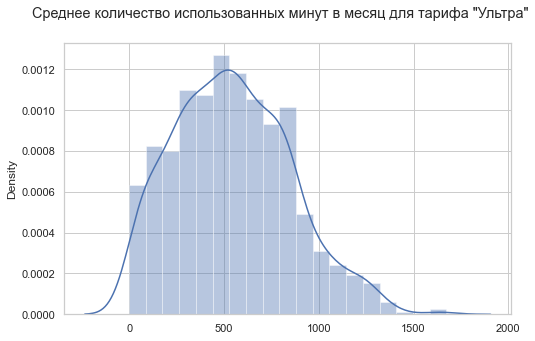

In [1065]:
sns_plot = sns.distplot(calls_duration_ultra)
fig = sns_plot.get_figure()
fig.suptitle('Среднее количество использованных минут в месяц для тарифа "Ультра"');

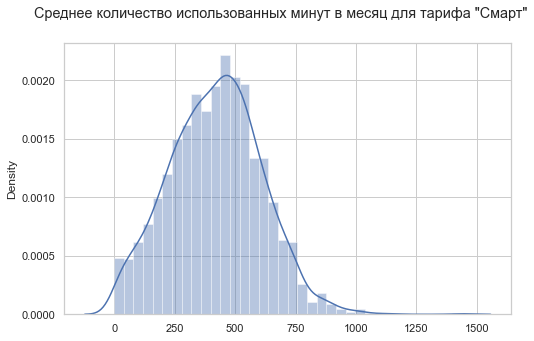

In [1066]:
sns_plot = sns.distplot(calls_duration_smart)
fig = sns_plot.get_figure()
fig.suptitle('Среднее количество использованных минут в месяц для тарифа "Смарт"');

Те же параметры посчитаем для сообщений и трафика

In [1031]:
messages_by_month = messages_by_month.merge(df_users[['user_id', 'tariff']], how='left', on='user_id')

In [1081]:
# Отберем значения для тарифа "Ультра" и "Смарт"
messages_ultra = messages_by_month.query('tariff == "ultra"').messages_quantity.values
messages_smart = messages_by_month.query('tariff == "smart"').messages_quantity.values

# Среднеквадратическое отклонение количества сообщений для тарифа "Ультра"
print('Среднеквадратическое отклонение количества сообщений для тарифа "Ультра"', np.std(messages_ultra).round(2))

# Среднеквадратическое отклонение количества сообщений для тарифа "Смарт"
print('Среднеквадратическое отклонение количества сообщений для тарифа "Смарт"', np.std(messages_smart).round(2))

# Среднее значение количества сообщений для тарифа "Ультра"
print('Среднее значение количества сообщений для тарифа "Ультра"', np.mean(messages_ultra).round(2))

# Среднее значение количества сообщений для тарифа "Смарт"
print('Среднее значение количества сообщений для тарифа "Смарт"', np.mean(messages_smart).round(2))

# Дисперсия количества сообщений для тарифа "Ультра"
print('Дисперсия количества сообщений для тарифа "Ультра"', np.var(messages_ultra).round(2))

# Дисперсия количества сообщений для тарифа "Смарт"
print('Дисперсия количества сообщений для тарифа "Смарт"', np.var(messages_smart).round(2))

Среднеквадратическое отклонение количества сообщений для тарифа "Ультра" 45.9
Среднеквадратическое отклонение количества сообщений для тарифа "Смарт" 26.78
Среднее значение количества сообщений для тарифа "Ультра" 61.16
Среднее значение количества сообщений для тарифа "Смарт" 38.72
Дисперсия количества сообщений для тарифа "Ультра" 2107.01
Дисперсия количества сообщений для тарифа "Смарт" 717.22


In [1090]:
# Посмотрим, на сколько % отличаются средние
round((61.16 - 38.72) * 100 / 61.16)

37

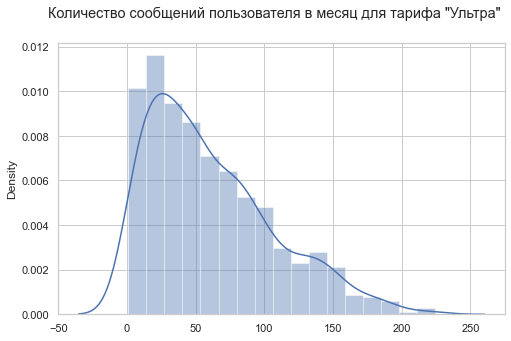

In [1082]:
sns_plot = sns.distplot(messages_ultra)
fig = sns_plot.get_figure()
fig.suptitle('Количество сообщений пользователя в месяц для тарифа "Ультра"');

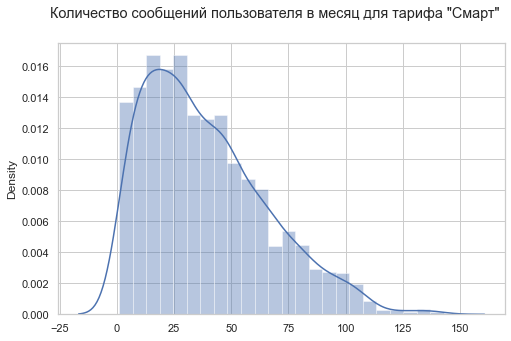

In [1083]:
sns_plot = sns.distplot(messages_smart)
fig = sns_plot.get_figure()
fig.suptitle('Количество сообщений пользователя в месяц для тарифа "Смарт"');

In [1033]:
internet_by_month = internet_by_month.merge(df_users[['user_id', 'tariff']], how='left', on='user_id')

In [1084]:
# Отберем значения для тарифа "Ультра" и "Смарт"
internet_ultra = internet_by_month.query('tariff == "ultra"').mb_used.values
internet_smart = internet_by_month.query('tariff == "smart"').mb_used.values

# Среднеквадратическое отклонение трафика для тарифа "Ультра"
print('Среднеквадратическое отклонение трафика для тарифа "Ультра"', np.std(internet_ultra).round(2))

# Среднеквадратическое отклонение трафика для тарифа "Смарт"
print('Среднеквадратическое отклонение трафика для тарифа "Смарт"', np.std(internet_smart).round(2))

# Среднее значение трафика для тарифа "Ультра"
print('Среднее значение трафика для тарифа "Ультра"', np.mean(internet_ultra).round(2))

# Среднее значение трафика для тарифа "Смарт"
print('Среднее значение трафика для тарифа "Смарт"', np.mean(internet_smart).round(2))

# Дисперсия трафика для тарифа "Ультра"
print('Дисперсия трафика для тарифа "Ультра"', np.var(internet_ultra).round(2))

# Дисперсия трафика для тарифа "Смарт"
print('Дисперсия трафика для тарифа "Смарт"', np.var(internet_smart).round(2))

Среднеквадратическое отклонение трафика для тарифа "Ультра" 9946.95
Среднеквадратическое отклонение трафика для тарифа "Смарт" 5867.51
Среднее значение трафика для тарифа "Ультра" 19686.77
Среднее значение трафика для тарифа "Смарт" 16236.47
Дисперсия трафика для тарифа "Ультра" 98941856.59
Дисперсия трафика для тарифа "Смарт" 34427641.48


In [1092]:
# Посмотрим, на сколько % отличаются средние
round((19686.77 - 16236.47) * 100 / 19686.77)

18

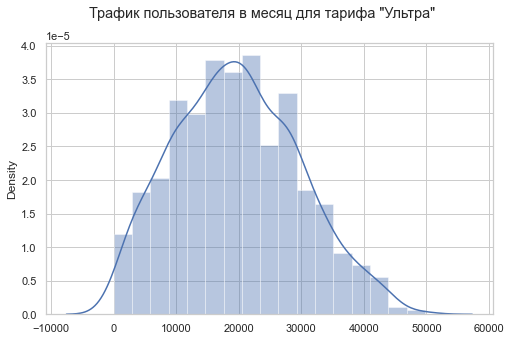

In [1085]:
sns_plot = sns.distplot(internet_ultra)
fig = sns_plot.get_figure()
fig.suptitle('Трафик пользователя в месяц для тарифа "Ультра"');

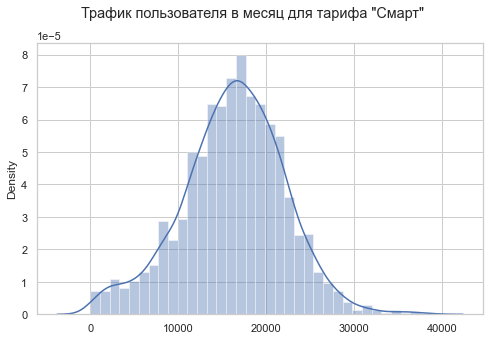

In [1086]:
sns_plot = sns.distplot(internet_smart)
fig = sns_plot.get_figure()
fig.suptitle('Трафик пользователя в месяц для тарифа "Смарт"');

Распределение величин похоже на нормальное, но с выраженной положительной асимметрией.
Выводы:
Пользователи тарифа Ультра больше разговаривают по телефону на 23%, на 18% больше используют интернет и почти на 37%  больше пользуются смс.
Стандартные отклонения данных тарифа Смарт меньше почти в 2 раза, это говорит о том, что средние значения данных тарифа Смарт более однородные, больший разброс средних значений соответствует тарифу Ультра.

### 4. Проверим гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются?

In [1095]:
total_income = total_income.merge(df_users[['user_id', 'tariff']], how='left', on='user_id')

In [1097]:
#Расчитаем среднее для каждого пользователя в течение года
total_income['monthly_mean'] = total_income.mean(axis=1)

In [1103]:
# Подготовим значения средней выручки пользователей тарифов «Ультра» и «Смарт» 
income_ultra = total_income.query('tariff == "ultra"').monthly_mean.values
income_smart = total_income.query('tariff == "smart"').monthly_mean.values

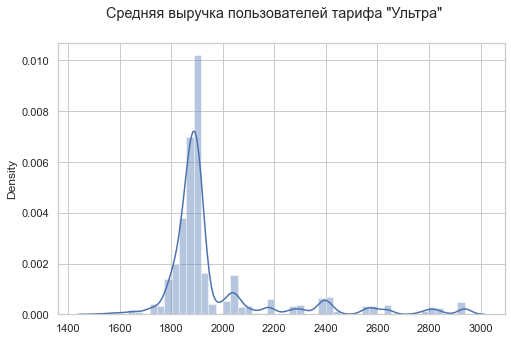

In [1105]:
sns_plot = sns.distplot(income_ultra)
fig = sns_plot.get_figure()
fig.suptitle('Средняя выручка пользователей тарифа "Ультра"');

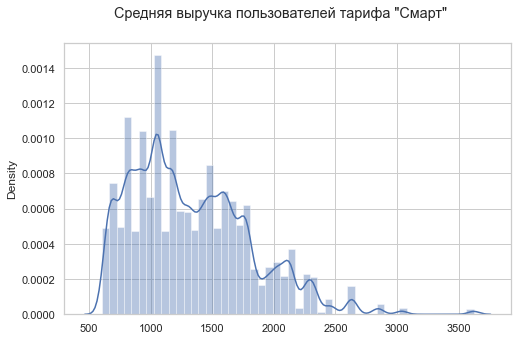

In [1106]:
sns_plot = sns.distplot(income_smart)
fig = sns_plot.get_figure()
fig.suptitle('Средняя выручка пользователей тарифа "Смарт"');

Распределение не похоже на нормальное, проведем тест Шапиро-Уилка и убедимся в этом

In [1107]:
st.shapiro(income_ultra)

ShapiroResult(statistic=0.6627858281135559, pvalue=0.0)

In [1108]:
st.shapiro(income_smart)

ShapiroResult(statistic=0.9469608068466187, pvalue=0.0)

pvalue < 0.05, значит распределение не является нормальным

Проведем тест на U-критерий Манна — Уитни. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов. Нулевая гипотеза: распределение признака в первой выборке соответствует распределению признака во второй выборке. Уровень значимости примем 0.05

In [1109]:
st.mannwhitneyu(income_ultra, income_smart)

MannwhitneyuResult(statistic=1096073798.0, pvalue=0.0)

In [1116]:
# Посмотрим насколько отличаются средние выручки
round(income_ultra.mean())

1970

In [1115]:
round(income_smart.mean())

1329

In [1114]:
round((income_ultra.mean() - income_smart.mean()) * 100 / income_ultra.mean())

33

Т.к. pvalue < 0.05 мы отвергаем нулевую гипотезу. Тест показал, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются статистически значимо. Прибыль тарифа Ультра больше (примерно на 33%).

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов?

In [1118]:
# Добавим в таблицу с выручкой столбец с городом
total_income = total_income.merge(df_users[['user_id', 'city']], how='left', on='user_id')

In [1120]:
# Создадим выборки
income_msk = total_income.query('city == "Москва"').monthly_mean.values
income_not_msk = total_income.query('city != "Москва"').monthly_mean.values

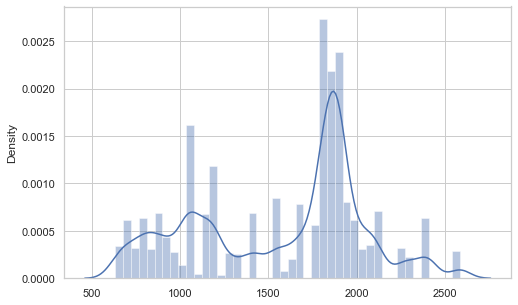

In [1122]:
ns_plot = sns.distplot(income_msk)
fig = sns_plot.get_figure()
fig.suptitle('Средняя выручка от пользователей из Москвы');

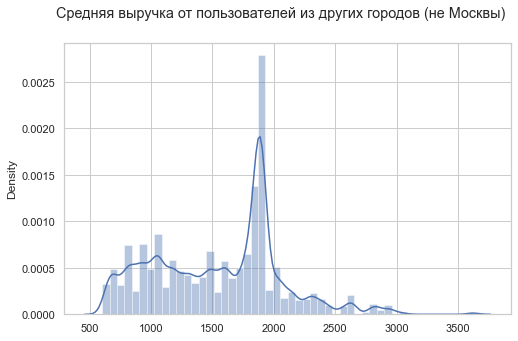

In [1123]:
sns_plot = sns.distplot(income_not_msk)
fig = sns_plot.get_figure()
fig.suptitle('Средняя выручка от пользователей из других городов (не Москвы)');

Проведем тест на U-критерий Манна — Уитни. Нулевая гипотеза: распределение признака в первой выборке соответствует распределению признака во второй выборке. Уровень значимости примем 0.05

In [1146]:
st.mannwhitneyu(income_msk, income_not_msk)[1] 

1.773189646045334e-34

In [1128]:
round(income_msk.mean())

1574

In [1127]:
round(income_not_msk.mean())

1553

In [1133]:
round((income_msk.mean() - income_not_msk.mean()) * 100 / income_msk.mean())

1

Т.к. pvalue < 0.05 мы отвергаем нулевую гипотезу. Тест показал, что средняя выручка от пользователей из Москвы и не из Москвы различается статистически значимо. Прибыль от москвичей больше (примерно на 1%). Можно попробовать проверить с помощью бутстрапа.

In [1142]:
# Создаем функцию для проверки гипотезы с помощью бутстрапа
def get_bootstrap(sample1, sample2, iterate=1000, alpha=0.05, statistic='mean', random_state=42):
    
    assert statistic in ('mean', 'median'), f'{statistic} not in correct statistics. Choose "mean" or "median"'
    np.random.seed(random_state)
    l = max(len(sample1), len(sample2))
    difference = []
    for i in range(iterate):
        s1 = sample1.sample(l, replace=True).values
        s2 = sample2.sample(l, replace=True).values
        if statistic == 'mean':
            diff = np.mean(s1 - s2)
        else: 
            diff = np.median(s1 - s2)
        difference.append(diff)
    low_quantile = alpha/2
    upper_quantile = 1 - low_quantile 
    ci = (np.quantile(difference, low_quantile), np.quantile(difference, upper_quantile))
    p1 = norm.cdf(0, loc=np.mean(difference), scale=np.std(difference))
    p2 = 1 - p1
    p = min(p1, p2)*2
    
    plt.hist(difference, bins = 50)

    with plt.style.context('bmh'):
        plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": difference, 
            "ci": ci, 
            "p_value": p
           }

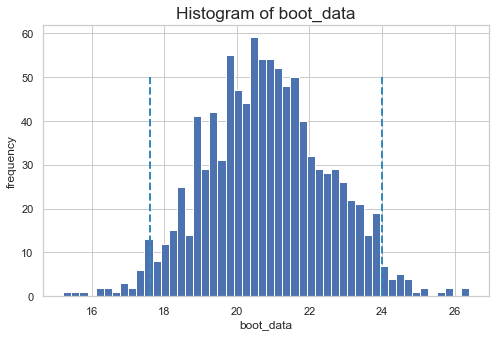

In [1143]:
result_mean = get_bootstrap(total_income.query('city == "Москва"').monthly_mean, 
                            total_income.query('city != "Москва"').monthly_mean, 
                            statistic='mean')

In [1144]:
result_mean['p_value']

1.6897442716853686e-34

In [1145]:
result_mean['ci']

(17.602235649330446, 24.002357071133176)

Применяя бутстрап с оценкой среднего, мы отклоняем нулевую гипотезу о равенстве средних и делаем вывод, что тестовая и контрольная выборка имеют различия

### Общие выводы
- Перед новым годом (29-31 декабря) несколько пользователей совершали существенно больше звонков/сообщений/интернет-соединений, чем совершается в другие дни
- Пользователи тарифа Ультра больше разговаривают по телефону на 23%, на 18% больше используют интернет и почти на 37% больше пользуются смс.
- Тариф "Ультра" приносит больше выручки, чем тариф "Смарт"
- Пользователи из Москвы приносят больше выручки, чем из других городов